In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

In [16]:
#sites inventory from https://www.sandiego.gov/sites/default/files/he_appd_adequatesitesreport_final_0.pdf
#then processed with Tabula to extract tables
HE_sites = pd.read_csv('he_appd_adequatesitesreport.csv')
#Tabula didn't read the SITE CATEGORY and COMMUNITY fields completely accurately for a few rows, so this is just fixing those errors
HE_sites['COMMUNITY'] = HE_sites['COMMUNITY'].fillna(HE_sites['SITE CATEGORY'])
HE_sites['SITE CATEGORY'] = HE_sites['SITE CATEGORY'].apply(lambda x: 'Vacant' if 'Vacant' in x else x)
HE_sites['SITE CATEGORY'] = HE_sites['SITE CATEGORY'].apply(lambda x: 'Potential Future Infill (Non-Vacant)' if 'Potential Future Infill (Non-Vacant)' in x else x)
HE_sites['COMMUNITY'] = HE_sites['COMMUNITY'].str.replace('Vacant ', '')
HE_sites['COMMUNITY'] = HE_sites['COMMUNITY'].str.replace('Potential Future Infill (Non-Vacant) ', '')
HE_sites.rename(columns={'8-DIGIT APN': 'apn'}, inplace=True)
print(len(HE_sites))
HE_sites = HE_sites.dropna(subset=['apn'])
HE_sites['apn'] = HE_sites['apn'].astype(int).astype(str)
print(len(HE_sites))

11806
11796


C:\Users\amjar\anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  if __name__ == '__main__':


In [6]:
#parcel geodata from https://data.sandiego.gov/datasets/address-points-apn/
apnlist = gpd.read_file('addrapn_datasd.geojson')
apnlist['apn'] = apnlist['apn'].astype(str).str[:-2]
#there are lots of duplicate apn numbers, which will mess up the merge
apnlist = apnlist.drop_duplicates(subset=['apn'])

In [12]:
print(len(HE_sites))
print(len(apnlist))

11796
273375


In [64]:
combined = pd.merge(HE_sites, apnlist, on='apn', how='left')
pd.set_option('display.max_columns', 100)
print(len(combined))
geo_sites = gpd.GeoDataFrame(combined, geometry='geometry')
geo_sites['lat'] = geo_sites.geometry.y
geo_sites['lon'] = geo_sites.geometry.x
geo_sites

AttributeError: 'Series' object has no attribute 'y'

In [63]:
geo_sites.to_file('SD_sites.shp')

C:\Users\amjar\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  """Entry point for launching an IPython kernel.


In [71]:
sites_csv = pd.DataFrame(geo_sites)
sites_csv.drop(['geometry'], axis=1, inplace=True)
sites_csv.to_csv('SD_sites.csv')

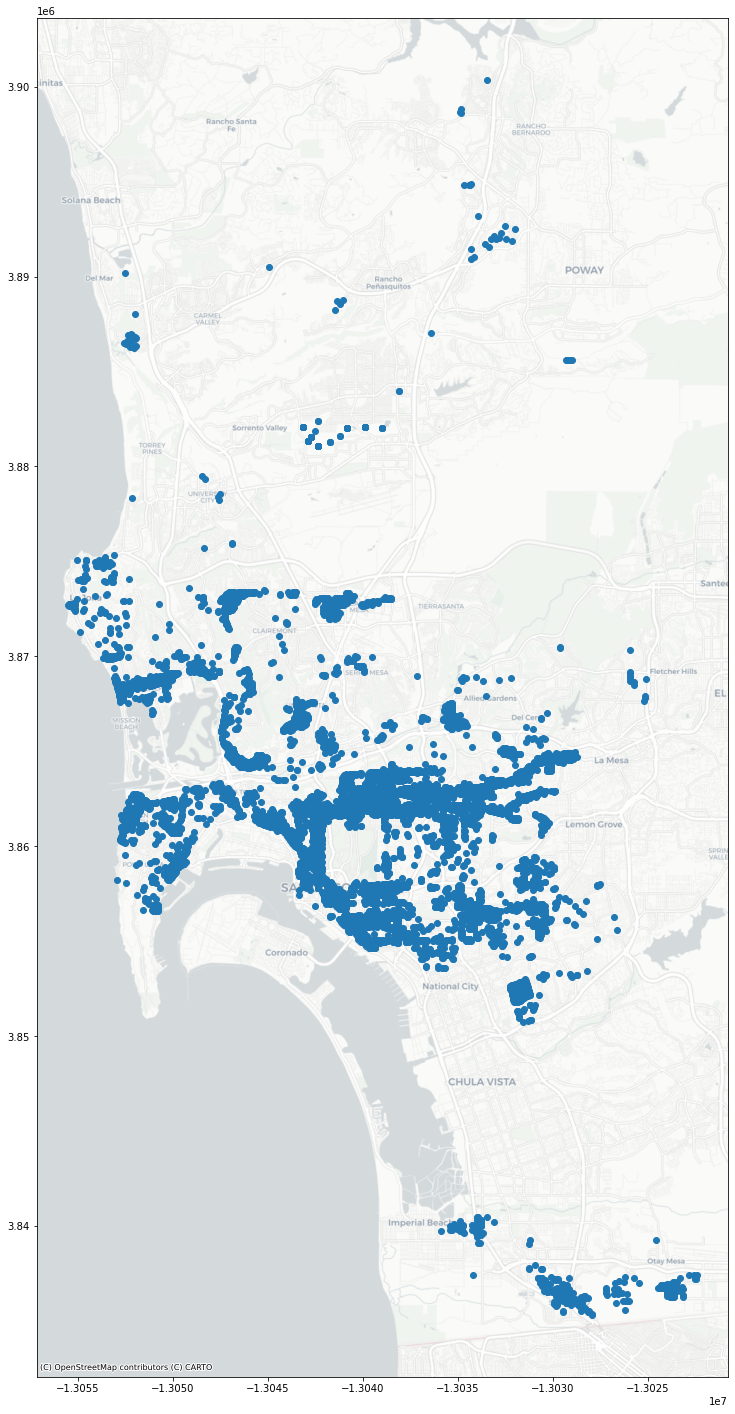

In [23]:
#just a basic plot to see if the process seemed to work
#the marker size is set to the number of low income units listed for each site
fig, ax = plt.subplots(figsize=(25,25))
geo_sites.to_crs(3857).plot(ax=ax) 
                            #markersize=geo_sites['NET POTENTIAL LOWER INCOME UNITS'])
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [43]:
#Census median household income data from censusreporter.org, by block group for City of San Diego
census = gpd.read_file('acs2019_5yr_B19013.geojson')
columnstokeep = ['geoid', 'name', 'B19013001', 'geometry']
census = census[columnstokeep]
census.columns = ['geoid', 'name', 'median_HH_income', 'geometry']
census['geoid'] = census['geoid'].str.replace('15000US', '')
print(len(census))
census = census.dropna(subset=['median_HH_income'])
census['income_group'] = pd.qcut(census['median_HH_income'], 3, labels=['Lower','Middle','Upper'])
print(len(census))

867
844


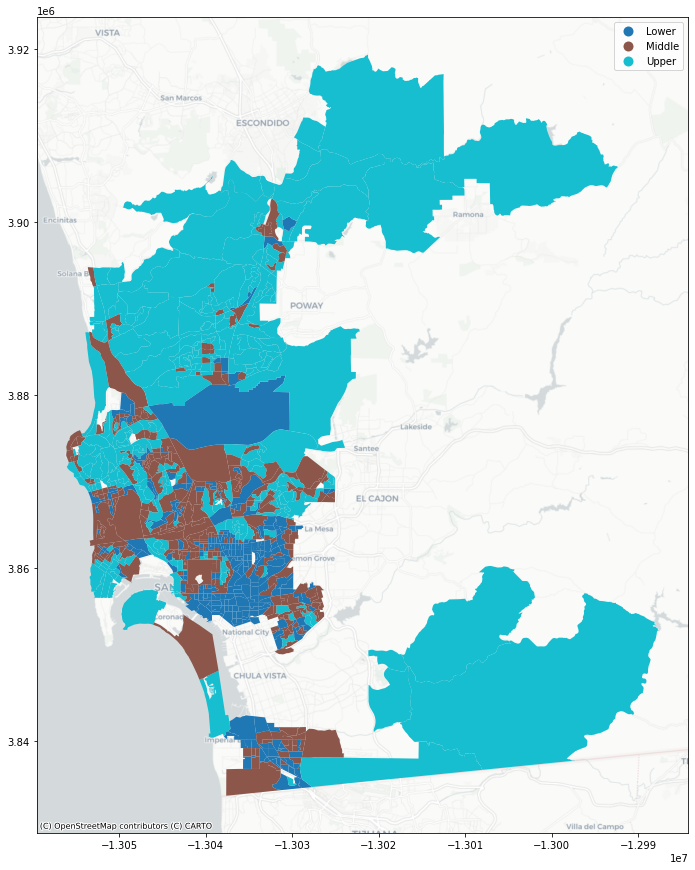

In [42]:
#quick view of San Diego block groups by lower/middle/upper income quintiles
fig, ax = plt.subplots(figsize=(15,15))
census.to_crs(3857).plot(ax=ax, column='income_group', legend=True)
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

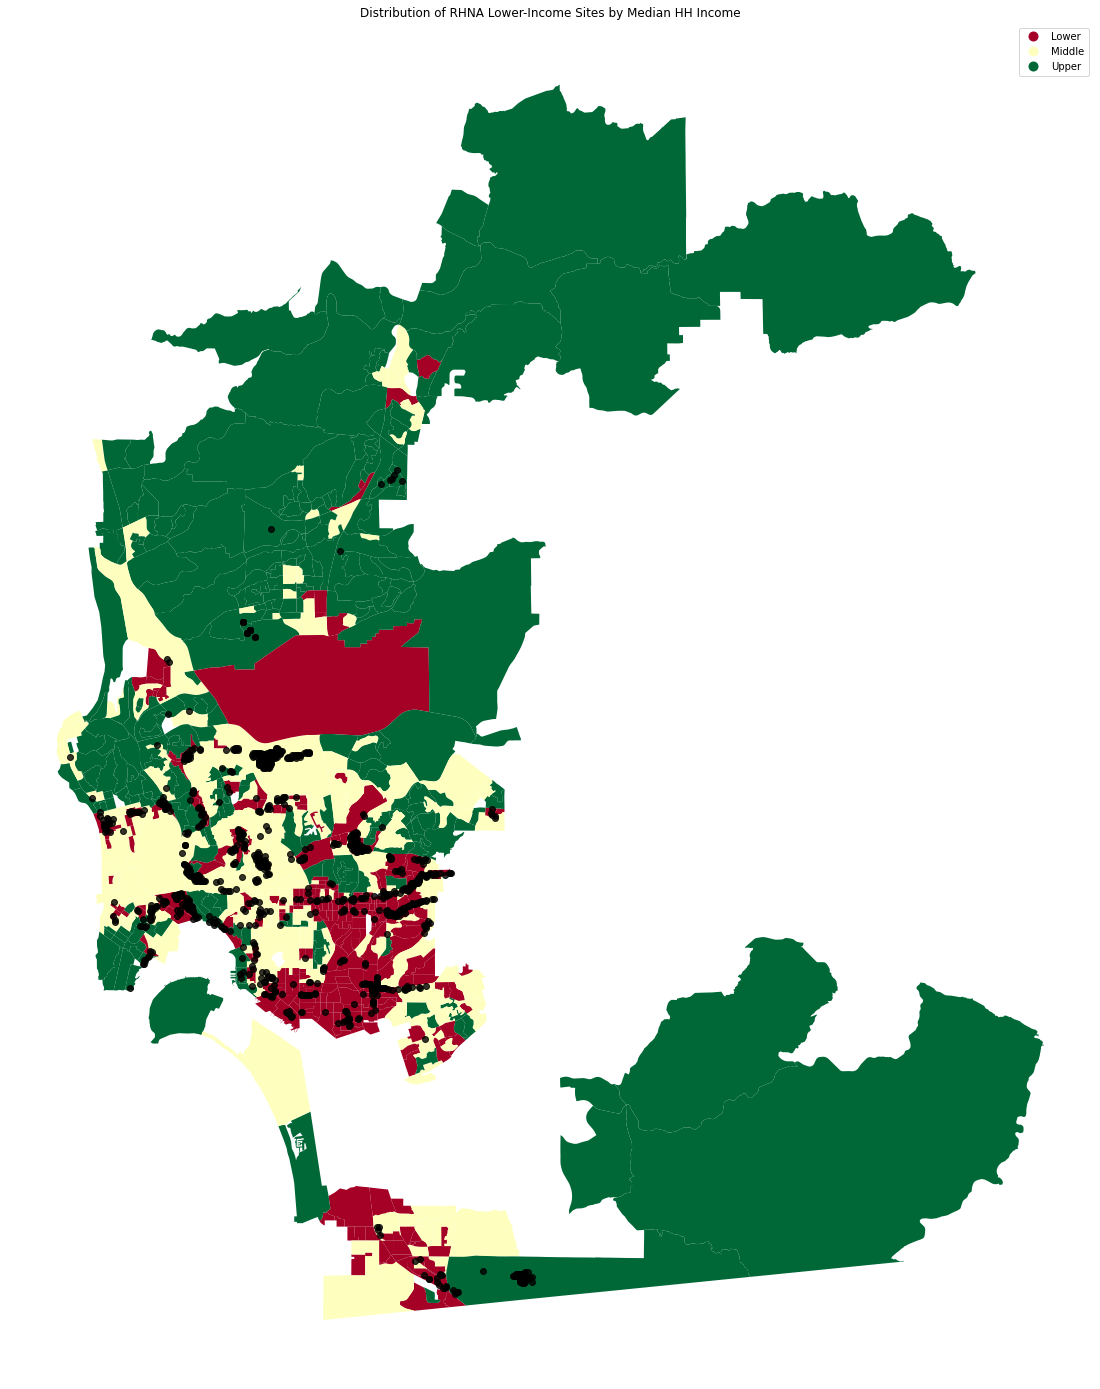

In [72]:
#MARTA base
base = census.to_crs(3857).plot(figsize=(25,25), column='income_group', cmap='RdYlGn', legend=True)
base.axis('off')
# add isochrones
geo_sites.to_crs(3857).loc[geo_sites['NET POTENTIAL LOWER INCOME UNITS'] > 0].plot(ax=base, color='black', alpha=.8)

# title
base.set_title('Distribution of RHNA Lower-Income Sites by Median HH Income')

# add a basemap
#ctx.add_basemap(base)
plt.savefig('SD_sites.png')